# Проект. Определение перспективного тарифа для телеком компании

## Глава 0. Входные данные
### Описание проекта
Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. 

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
#### Описание тарифов
##### Тариф «Смарт»
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

##### Тариф «Ультра»
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей  

##### Обратить внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

#### Пути к файлам:
- /datasets/calls.csv
- /datasets/internet.csv
- /datasets/messages.csv
- /datasets/tariffs.csv
- /datasets/users.csv

#### Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

#### Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

#### Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

#### Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

#### Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

## Глава 1. Открытие файлов с данными и изучение общей информации

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from scipy import stats as st
from scipy.stats import norm

Напишем функции first_view для ознакомления с каждой из таблиц и вызовем ее для каждой

In [2]:
def first_view(df):
    print(df.info()) 
    return df.head(10)

In [3]:
df_calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')
first_view(df_calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


    Столбец call_date изменить на формат datetime, столбец duration разобраться с 0, округлить значения до целого вверх.

In [4]:
df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv')
first_view(df_internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


    Столбец session_date изменить на формат datetime, mb_used округлить значения до целого вверх.

In [5]:
df_messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')
first_view(df_messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


    Столбец message_date изменить на формат datetime.

In [6]:
df_tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')
first_view(df_tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


    В этой таблице с данными все хорошо.

In [7]:
df_users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')
first_view(df_users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


    В столбце churn_date есть пропуски NaN, churn_date и reg_date изменить на формат datetime

## Выводы:
   В целом данные не имеют сложностей в замене пропусков и форматирования самих данных. Необходимо разобраться с 0 в таблице звонков, округлить звонки и интернет трафик до целого вверх, привести данные даты к необходимому формату данных 


## Глава 2. Подготовка данных

Заполним пропуски в df_users в столбце churn_date на 2018-12-31, так как в исследование нас интересует только 2018 год, то и верхняя граница будет соответствующая.

In [8]:
df_users['churn_date'] = df_users['churn_date'].fillna('2018-12-31')

Напишем функцию date_convert для изменения формата даты на datetime. Заменим во всех таблицах со столбцами даты.

In [9]:
def date_convert(df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d')

In [10]:
date_convert(df_calls, 'call_date')
date_convert(df_internet, 'session_date')
date_convert(df_messages, 'message_date')
date_convert(df_users, 'reg_date')
date_convert(df_users, 'churn_date')

Проверим на датафрейме df_users результат:

In [11]:
first_view(df_users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    500 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2018-12-31,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2018-12-31,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2018-12-31,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,2018-12-31,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,2018-12-31,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,2018-12-31,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,2018-12-31,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,2018-12-31,Пермь,Василиса,Блинова,2018-03-22,smart


Проверим количество звонков в таблице df_calls со значением 0.

In [12]:
df_calls[df_calls['duration'] == 0]['duration'].count()

39613

    Значений почти 40 тысяч. Значения присутствуют в таблице, значит звонок был совершен. Вероятнее всего, меньше 1 сек. Но т.к. «Мегалайн» всегда округляет вверх значения минут, следовательно, считает их как 1 минута. Заменим 0 на 1 мин

In [13]:
df_calls['duration'] = df_calls['duration'].replace(0, 1)

Округлим значения столбцов с минутами разговора и траффиком интернета до целого вверх.  
Далее проверим правильность, вызвав снова функцию first_view

In [14]:
df_calls['duration'] = df_calls['duration'].apply(np.ceil)
#df_internet['mb_used'] = df_internet['mb_used'].apply(np.ceil)

Проверим результат на датафреймах df_calls и df_internet

In [15]:
first_view(df_calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,1.0,1000
1,1000_1,2018-08-17,1.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000
5,1000_5,2018-11-02,1.0,1000
6,1000_6,2018-10-18,1.0,1000
7,1000_7,2018-08-22,19.0,1000
8,1000_8,2018-09-15,19.0,1000
9,1000_9,2018-08-15,1.0,1000


In [16]:
first_view(df_internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB
None


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


Проверим таблицы на дубликаты, вызвав метод .duplicated().

In [17]:
[df.duplicated().sum() for df in (df_calls, df_messages, df_internet, df_users)]

[0, 0, 0, 0]

Добавим в ДатаФреймы, где есть столбцы с датами, столбцы с месяцами для дальнейшей работы с датами. 
Для этого напишем функцию add_month

In [18]:
def add_month(df, date):
    df['month'] = df[date].dt.month

In [19]:
add_month(df_calls, 'call_date')
add_month(df_internet, 'session_date')
add_month(df_messages, 'message_date')

Проверим результат на датафреймах df_messages

In [20]:
df_messages

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


Создадим срез из df_user, включающий столбцы 'user_id' и 'tariff'. Далее добавим новый столбец 'month_reg', с какого месяца пользователь использует тариф.

In [21]:
user_tariff = df_users.loc[:, ['user_id', 'tariff']]
user_tariff['month_reg'] = df_users['reg_date'].dt.month
user_tariff

,user_id,tariff,month_reg
0,1000,ultra,5
1,1001,smart,11
2,1002,smart,6
3,1003,ultra,8
4,1004,ultra,5
...,...,...,...
495,1495,ultra,8
496,1496,smart,1
497,1497,smart,10
498,1498,smart,7


### Количество сделанных звонков и израсходованных минут разговора по месяцам

Для подсчета количества сделанных звонков и израсходованных минут разговора по месяцам, создадим сводную таблицу по звонкам и применим методы count и sum. Для наглядности запоним пропуски пробелами.

In [22]:
calls_duration_pivot = df_calls.pivot_table(index=['user_id'], columns='month', values='duration', aggfunc=['count','sum'])
calls_duration_pivot.fillna('')

count                                                 sum            \
month      1   2   3   4   5   6   7   8    9    10   11   12  1    2    3    
user_id                                                                       
1000                       22  43  47  52   58   57   43   46                 
1001                                                  59   63                 
1002                           15  26  42   36   33   32   33                 
1003                                   55  134  108  115  108                 
1004                        9  31  22  19   26   29   19   21                 
...       ...  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ..  ...  ...   
1495                                   17  112  152  129  155                 
1496        7  77  79  67  63  74  73  88   68   72   80   80  49  606  569   
1497                                             66   64   71                 
1498                               23  57   59   41                           
1499                                         9   68   74   69                 

                                                        
month     4    5    6    7    8    9     10   11    12  
user_id                                                 
1000          164  187  346  418  478   363  344   341  
1001                                         444   430  
1002               118  219  294  217   221  250   242  
1003                         392  990   866  844   822  
1004           37  177  137  138  125   153  121   136  
...      ...  ...  ...  ...  ...  ...   ...  ...   ...  
1495                          96  830  1056  971  1066  
1496     536  497  572  592  553  496   466  676   533  
1497                                    506  387   558  
1498                    178  414  477   258             
1499                               71   473  624   505  

[492 rows x 24 columns]

### Количество отправленных сообщений по месяцам

Для подсчета количества отправленных сообщений по месяцам, создадим сводную таблицу по сообщениям и применим метод count. Для наглядности запоним пропуски пробелами.

In [23]:
messages_pivot = df_messages.pivot_table(index=['user_id'], columns='month', values='message_date', aggfunc='count')
messages_pivot.fillna('')

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,,,,,22,60,75,81,57,73,58,70
1002,,,,,,4,11,13,4,10,16,12
1003,,,,,,,,37,91,83,94,75
1004,,,,,95,134,181,151,146,165,158,162
1005,7,38,56,41,42,47,56,64,52,44,51,54
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,,,,,,,,13,82,82,79,84
1496,9,45,46,49,40,35,42,41,29,35,46,51
1497,,,,,,,,,,20,14,17


### Объем израсходованного интернет-трафика по месяцам

Для подсчета объема израсходованного интернет-трафика по месяцам, создадим сводную таблицу по интернет-трафику и применим метод sum. Для наглядности запоним пропуски пробелами.

In [24]:
internet_pivot = df_internet.pivot_table(index=['user_id'], columns='month', values='mb_used', aggfunc='sum')
internet_pivot.fillna('')

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,,,,,2253.49,23233.8,14003.6,14055.9,14568.9,14702.5,14756.5,9817.61
1001,,,,,,,,,,,18429.3,14036.7
1002,,,,,,10856.8,17580.1,20319.3,16691.1,13888.3,18587.3,18113.7
1003,,,,,,,,8565.21,12468.9,14768.1,11356.9,10121.5
1004,,,,,13404,17600,22229.6,28584.4,15109,18475.4,15616,18021
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,,,,,,,,2614.07,33067.6,29363,38939.1,23426.8
1496,3762.73,28489.7,24959,21074.7,23709.8,20134.3,24364.8,23530,26934.7,28183.2,25063.4,20736.2
1497,,,,,,,,,,11500.3,14156.1,19918.6


### Помесячная выручка с каждого пользователя

Для подсчета выручки с каждого пользователя сначала создадим общую сводную таблицу со звонками, сообщениями и интренет трафиком.

In [25]:
calls_pivot = df_calls.pivot_table(index=['user_id'], columns='month', values='duration', aggfunc='sum')
big_pivot =  (user_tariff.merge(calls_pivot, on='user_id', how='left')
                         .merge(internet_pivot, on='user_id', how='left')
                         .merge(messages_pivot, on='user_id', how='left')
             )
big_pivot

,user_id,tariff,month_reg,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,ultra,5,NaN,NaN,NaN,NaN,164.0,187.0,346.0,418.0,478.0,363.0,344.0,341.0,NaN,NaN,NaN,NaN,2253.49,23233.77,14003.64,14055.93,14568.91,14702.49,14756.47,9817.61,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1,1001,smart,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,444.0,430.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18429.34,14036.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1002,smart,6,NaN,NaN,NaN,NaN,NaN,118.0,219.0,294.0,217.0,221.0,250.0,242.0,NaN,NaN,NaN,NaN,NaN,10856.82,17580.10,20319.26,16691.08,13888.25,18587.28,18113.73,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0
3,1003,ultra,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,392.0,990.0,866.0,844.0,822.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8565.21,12468.87,14768.14,11356.89,10121.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0
4,1004,ultra,5,NaN,NaN,NaN,NaN,37.0,177.0,137.0,138.0,125.0,153.0,121.0,136.0,NaN,NaN,NaN,NaN,13403.98,17600.02,22229.58,28584.37,15109.03,18475.44,15616.02,18021.04,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,ultra,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0,830.0,1056.0,971.0,1066.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2614.07,33067.62,29363.00,38939.11,23426.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,82.0,82.0,79.0,84.0
496,1496,smart,1,49.0,606.0,569.0,536.0,497.0,572.0,592.0,553.0,496.0,466.0,676.0,533.0,3762.73,28489.67,24959.0,21074.67,23709.75,20134.31,24364.76,23530.03,26934.65,28183.17,25063.40,20736.15,9.0,45.0,46.0,49.0,40.0,35.0,42.0,41.0,29.0,35.0,46.0,51.0
497,1497,smart,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,506.0,387.0,558.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11500.29,14156.08,19918.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,14.0,17.0
498,1498,smart,7,NaN,NaN,NaN,NaN,NaN,NaN,178.0,414.0,477.0,258.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7476.24,24235.21,22134.41,20579.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,62.0,44.0,42.0,NaN,NaN


Далее разделим данную сводную таблицу в соответствии с тарифами «Смарт» и «Ультра», создав датафреймы

In [26]:
smart_users = big_pivot[big_pivot['tariff'] == 'smart']
ultra_users = big_pivot[big_pivot['tariff'] == 'ultra']
smart_users = pd.DataFrame(smart_users)
ultra_users = pd.DataFrame(ultra_users)

Ввызовем датафрейм df_tariffs для удобства написания функций

In [27]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Напишем функции для расчета расходов клиентов сверх тарифа «Ультра». Далее циклами прогоним каждый столбец с минутами, сообщениями и интернет трафиком на наличие сверх лимита тарифа и посчитаем дополнительную стоимость.

In [28]:
def calls_cost_in_ultra(value):
        if value > df_tariffs.loc[1, 'minutes_included']:
            cost = (value - df_tariffs.loc[1, 'minutes_included']) * df_tariffs.loc[1, 'rub_per_minute']
        else:
            cost = 0
        return (cost)    

def internet_cost_in_ultra(value):
        if value > df_tariffs.loc[1, 'mb_per_month_included']:
            cost = (value - df_tariffs.loc[1, 'mb_per_month_included']) / 1024 * df_tariffs.loc[1, 'rub_per_gb']
        else:
            cost = 0
        return (cost)    

def messages_cost_in_ultra(value):
        if value > df_tariffs.loc[1, 'messages_included']:
            cost = (value - df_tariffs.loc[1, 'messages_included']) * df_tariffs.loc[1, 'rub_per_message']
        else:
            cost = 0
        return (cost)
    
for i in range(1,13):
    ultra_users[str(i)+'_x'] = ultra_users[str(i)+'_x'].apply(calls_cost_in_ultra)
for i in range(1,13):
    ultra_users[str(i)+'_y'] = ultra_users[str(i)+'_y'].apply(internet_cost_in_ultra)
for i in range(1,13):
    ultra_users[i] = ultra_users[i].apply(messages_cost_in_ultra)
ultra_users

,user_id,tariff,month_reg,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,ultra,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
3,1003,ultra,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
4,1004,ultra,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
13,1013,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
16,1016,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,1476,ultra,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
485,1485,ultra,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
491,1491,ultra,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0
493,1493,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1760.036133,0,0,0,0,0,0,0,0,0,0,0,0


Добавим столбцы с ежемесячной платой, но сначала присвоим им значение месяца регистрации.

In [29]:
for i in range(1,13):
    ultra_users[str(i)+'_fee'] = ultra_users['month_reg']
ultra_users = ultra_users.reset_index(drop=True)

Перебирая в цикле, если значение месяца >= месяца регистрации, то заменим на ежемесячную плату, иначе 0.  
Так получим месяцы владения тарифом каждого пользователя

In [30]:
for j in range (0, len(ultra_users)):  
    for i in range(1,13):
        if i >= ultra_users.loc[j, str(i) + '_fee']:
            ultra_users.loc[j, str(i) + '_fee'] = df_tariffs.loc[1, 'rub_monthly_fee']
        else:
            ultra_users.loc[j, str(i) + '_fee'] = 0
ultra_users

,user_id,tariff,month_reg,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,1,2,3,4,5,6,7,8,9,10,11,12,1_fee,2_fee,3_fee,4_fee,5_fee,6_fee,7_fee,8_fee,9_fee,10_fee,11_fee,12_fee
0,1000,ultra,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
1,1003,ultra,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950
2,1004,ultra,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
3,1013,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950
4,1016,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1476,ultra,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,1950
145,1485,ultra,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950
146,1491,ultra,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,1950
147,1493,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1760.036133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950


Циклом суммируем значения дполнительной оплаты за звонки, сообщения, интернет трафик и ежемесячную плату для каждого клиента

In [31]:
for i in range(1,13):
    ultra_users[str(i) + '_total'] = ultra_users[str(i)+'_x'] + ultra_users[str(i)+'_y'] + ultra_users[i] + ultra_users[str(i) + '_fee']
ultra_users 

,user_id,tariff,month_reg,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,1,2,3,4,5,6,7,8,9,10,11,12,1_fee,2_fee,3_fee,4_fee,5_fee,6_fee,7_fee,8_fee,9_fee,10_fee,11_fee,12_fee,1_total,2_total,3_total,4_total,5_total,6_total,7_total,8_total,9_total,10_total,11_total,12_total
0,1000,ultra,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.000000,1950.0,1950.000000,1950.000000
1,1003,ultra,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.000000,1950.0,1950.000000,1950.000000
2,1004,ultra,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.000000,1950.0,1950.000000,1950.000000
3,1013,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1950.000000,1950.000000
4,1016,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1950.000000,1950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1476,ultra,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,1950,0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.000000,1950.0,1950.000000,1950.000000
145,1485,ultra,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1950.000000
146,1491,ultra,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,1950,0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.000000,1950.0,1950.000000,1950.000000
147,1493,ultra,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1760.036133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1950,1950,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1950.000000,3710.036133


Сделаем срез из предыдущей таблицы, получив только Id пользователя, его тариф , дату регистрации и ежемесячный расход. Для наглядности вернем целочисленные значения

In [32]:
ultra_total = ultra_users[['user_id', 'tariff', 'month_reg', '1_total', '2_total', '3_total', '4_total', '5_total', '6_total', '7_total', '8_total', '9_total', '10_total', '11_total', '12_total']]
ultra_total = pd.DataFrame(ultra_total)

for i in range (1,13):
    ultra_total[str(i) + '_total'] = ultra_total[str(i) + '_total'].astype('int')
ultra_total

,user_id,tariff,month_reg,1_total,2_total,3_total,4_total,5_total,6_total,7_total,8_total,9_total,10_total,11_total,12_total
0,1000,ultra,5,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
1,1003,ultra,8,0,0,0,0,0,0,0,1950,1950,1950,1950,1950
2,1004,ultra,5,0,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950
3,1013,ultra,11,0,0,0,0,0,0,0,0,0,0,1950,1950
4,1016,ultra,11,0,0,0,0,0,0,0,0,0,0,1950,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1476,ultra,4,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,1950
145,1485,ultra,12,0,0,0,0,0,0,0,0,0,0,0,1950
146,1491,ultra,4,0,0,0,1950,1950,1950,1950,1950,1950,1950,1950,1950
147,1493,ultra,11,0,0,0,0,0,0,0,0,0,0,1950,3710


Ппроделаем тоже самое для пользователей тарифа smart

In [33]:
def calls_cost_in_smart(value):
        if value > df_tariffs.loc[0, 'minutes_included']:
            cost = (value - df_tariffs.loc[0, 'minutes_included']) * df_tariffs.loc[0, 'rub_per_minute']
        else:
            cost = 0
        return (cost)    

def internet_cost_in_smart(value):
        if value > df_tariffs.loc[0, 'mb_per_month_included']:
            cost = (value - df_tariffs.loc[0, 'mb_per_month_included']) / 1024 * df_tariffs.loc[0, 'rub_per_gb']
        else:
            cost = 0
        return (cost)    
def messages_cost_in_smart(value):
        if value > df_tariffs.loc[0, 'messages_included']:
            cost = (value - df_tariffs.loc[0, 'messages_included']) * df_tariffs.loc[0, 'rub_per_message']
        else:
            cost = 0
        return (cost)
    
for i in range(1,13):
    smart_users[str(i)+'_x'] = smart_users[str(i)+'_x'].apply(calls_cost_in_smart)
for i in range(1,13):
    smart_users[str(i)+'_y'] = smart_users[str(i)+'_y'].apply(internet_cost_in_smart)
for i in range(1,13):
    smart_users[i] = smart_users[i].apply(messages_cost_in_smart)
smart_users

,user_id,tariff,month_reg,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,1,2,3,4,5,6,7,8,9,10,11,12
1,1001,smart,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,599.480469,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1002,smart,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,433.613281,968.605469,259.976563,0.000000,630.328125,537.837891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1005,smart,1,0.0,0.0,360.0,708.0,318.0,369.0,252.0,378.0,0.0,735.0,186.0,339.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,18.0,0.0,0.0,0.0,18.0,42.0,6.0,0.0,3.0,12.0
6,1006,smart,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,376.548828,0.000000,0.000000,0.000000,901.875000,770.255859,31.548828,846.992187,0.000000,608.615234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1007,smart,4,0.0,0.0,0.0,0.0,0.0,174.0,267.0,0.0,522.0,0.0,282.0,0.0,0.0,0.000000,0.000000,0.000000,454.544922,0.000000,57.941406,1043.046875,0.000000,0.000000,197.189453,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,1494,smart,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,312.990234,470.164063,525.869141,441.642578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,1496,smart,1,0.0,318.0,207.0,108.0,0.0,216.0,276.0,159.0,0.0,0.0,528.0,99.0,0.0,2564.388672,1874.804688,1116.146484,1630.810547,932.482422,1758.742188,1595.708984,2260.673828,2504.525391,1895.195313,1050.029297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
497,1497,smart,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,174.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,890.351562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,1498,smart,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1733.439453,1323.126953,1019.406250,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0


In [34]:
for i in range(1,13):
    smart_users[str(i)+'_fee'] = smart_users['month_reg']
smart_users = smart_users.reset_index(drop=True)

In [35]:
for j in range (0, len(smart_users)):  
    for i in range(1,13):
        if i >= smart_users.loc[j, str(i) + '_fee']:
            smart_users.loc[j, str(i) + '_fee'] = df_tariffs.loc[0, 'rub_monthly_fee']
        else:
            smart_users.loc[j, str(i) + '_fee'] = 0
smart_users

,user_id,tariff,month_reg,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,1,2,3,4,5,6,7,8,9,10,11,12,1_fee,2_fee,3_fee,4_fee,5_fee,6_fee,7_fee,8_fee,9_fee,10_fee,11_fee,12_fee
0,1001,smart,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,599.480469,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,550,550
1,1002,smart,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,433.613281,968.605469,259.976563,0.000000,630.328125,537.837891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,550,550,550,550,550,550,550
2,1005,smart,1,0.0,0.0,360.0,708.0,318.0,369.0,252.0,378.0,0.0,735.0,186.0,339.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,18.0,0.0,0.0,0.0,18.0,42.0,6.0,0.0,3.0,12.0,550,550,550,550,550,550,550,550,550,550,550,550
3,1006,smart,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,376.548828,0.000000,0.000000,0.000000,901.875000,770.255859,31.548828,846.992187,0.000000,608.615234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,550,550,550,550,550,550,550,550,550,550,550
4,1007,smart,4,0.0,0.0,0.0,0.0,0.0,174.0,267.0,0.0,522.0,0.0,282.0,0.0,0.0,0.000000,0.000000,0.000000,454.544922,0.000000,57.941406,1043.046875,0.000000,0.000000,197.189453,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,550,550,550,550,550,550,550,550,550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1494,smart,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,312.990234,470.164063,525.869141,441.642578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,550,550,550,550,550
347,1496,smart,1,0.0,318.0,207.0,108.0,0.0,216.0,276.0,159.0,0.0,0.0,528.0,99.0,0.0,2564.388672,1874.804688,1116.146484,1630.810547,932.482422,1758.742188,1595.708984,2260.673828,2504.525391,1895.195313,1050.029297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,550,550,550,550,550,550,550,550,550,550,550,550
348,1497,smart,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,174.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,890.351562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,550,550,550
349,1498,smart,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1733.439453,1323.126953,1019.406250,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,550,550,550,550,550,550


In [36]:
for i in range(1,13):
    smart_users[str(i) + '_total'] = smart_users[str(i)+'_x'] + smart_users[str(i)+'_y'] + smart_users[i] + smart_users[str(i) + '_fee']
smart_users

,user_id,tariff,month_reg,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,1,2,3,4,5,6,7,8,9,10,11,12,1_fee,2_fee,3_fee,4_fee,5_fee,6_fee,7_fee,8_fee,9_fee,10_fee,11_fee,12_fee,1_total,2_total,3_total,4_total,5_total,6_total,7_total,8_total,9_total,10_total,11_total,12_total
0,1001,smart,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,599.480469,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,550,550,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1149.480469,550.000000
1,1002,smart,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,433.613281,968.605469,259.976563,0.000000,630.328125,537.837891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,550,550,550,550,550,550,550,0.0,0.000000,0.000000,0.000000,0.000000,550.000000,983.613281,1518.605469,809.976563,550.000000,1180.328125,1087.837891
2,1005,smart,1,0.0,0.0,360.0,708.0,318.0,369.0,252.0,378.0,0.0,735.0,186.0,339.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,18.0,0.0,0.0,0.0,18.0,42.0,6.0,0.0,3.0,12.0,550,550,550,550,550,550,550,550,550,550,550,550,550.0,550.000000,928.000000,1258.000000,868.000000,919.000000,820.000000,970.000000,556.000000,1285.000000,739.000000,901.000000
3,1006,smart,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,376.548828,0.000000,0.000000,0.000000,901.875000,770.255859,31.548828,846.992187,0.000000,608.615234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,550,550,550,550,550,550,550,550,550,550,550,0.0,550.000000,926.548828,550.000000,550.000000,550.000000,1451.875000,1320.255859,581.548828,1396.992187,550.000000,1158.615234
4,1007,smart,4,0.0,0.0,0.0,0.0,0.0,174.0,267.0,0.0,522.0,0.0,282.0,0.0,0.0,0.000000,0.000000,0.000000,454.544922,0.000000,57.941406,1043.046875,0.000000,0.000000,197.189453,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,550,550,550,550,550,550,550,550,550,0.0,0.000000,0.000000,550.000000,1004.544922,724.000000,874.941406,1593.046875,1072.000000,550.000000,1029.189453,550.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1494,smart,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,312.990234,470.164063,525.869141,441.642578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,550,550,550,550,550,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,550.000000,892.990234,1020.164063,1075.869141,991.642578
347,1496,smart,1,0.0,318.0,207.0,108.0,0.0,216.0,276.0,159.0,0.0,0.0,528.0,99.0,0.0,2564.388672,1874.804688,1116.146484,1630.810547,932.482422,1758.742188,1595.708984,2260.673828,2504.525391,1895.195313,1050.029297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,550,550,550,550,550,550,550,550,550,550,550,550,550.0,3432.388672,2631.804688,1774.146484,2180.810547,1698.482422,2584.742188,2304.708984,2810.673828,3054.525391,2973.195312,1702.029297
348,1497,smart,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,174.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,890.351562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,550,550,550,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,568.000000,550.000000,1614.351562
349,1498,smart,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1733.439453,1323.126953,1019.406250,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,550,550,550,550,550,550,0.0,0.000000,0.000000,0

In [37]:
smart_total = smart_users[['user_id', 'tariff', 'month_reg', '1_total', '2_total', '3_total', '4_total', '5_total', '6_total', '7_total', '8_total', '9_total', '10_total', '11_total', '12_total']]
smart_total = pd.DataFrame(smart_total)

for i in range (1,13):
    smart_total[str(i) + '_total'] = smart_total[str(i) + '_total'].astype('int')
smart_total

,user_id,tariff,month_reg,1_total,2_total,3_total,4_total,5_total,6_total,7_total,8_total,9_total,10_total,11_total,12_total
0,1001,smart,11,0,0,0,0,0,0,0,0,0,0,1149,550
1,1002,smart,6,0,0,0,0,0,550,983,1518,809,550,1180,1087
2,1005,smart,1,550,550,928,1258,868,919,820,970,556,1285,739,901
3,1006,smart,2,0,550,926,550,550,550,1451,1320,581,1396,550,1158
4,1007,smart,4,0,0,0,550,1004,724,874,1593,1072,550,1029,550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1494,smart,8,0,0,0,0,0,0,0,550,892,1020,1075,991
347,1496,smart,1,550,3432,2631,1774,2180,1698,2584,2304,2810,3054,2973,1702
348,1497,smart,10,0,0,0,0,0,0,0,0,0,568,550,1614
349,1498,smart,7,0,0,0,0,0,0,550,2319,1873,1569,550,550


## Выводы:
Приведя данные, удобные для исследования(заполнив пропуски и изменив формат данных), получили два датафрейма по пользователям тарифа "Смарт" и "Ультра". Уже при первом приближении видно, что они отличаются и расходы по двум тарифам, вероятнее всего, отличаются друг от друга.

## Глава 3. Анализ данных
Для описания поведение клиентов оператора, исходя из выборки, постоим по 3 таблицы(звонки, сообщения, интернет трафик) для каждого тарифа(Смарт, Ультра).

In [38]:
users_calls_pivot = user_tariff.merge(calls_pivot, on='user_id', how='left')
users_internet_pivot = user_tariff.merge(internet_pivot, on='user_id', how='left')
users_messages_pivot = user_tariff.merge(messages_pivot, on='user_id', how='left')

smart_users_calls = users_calls_pivot.query('tariff == "smart"').reset_index(drop=True).fillna(0)
ultra_users_calls = users_calls_pivot.query('tariff == "ultra"').reset_index(drop=True).fillna(0)
smart_users_internet = users_internet_pivot.query('tariff == "smart"').reset_index(drop=True).fillna(0)
ultra_users_internet = users_internet_pivot.query('tariff == "ultra"').reset_index(drop=True).fillna(0)
smart_users_messages = users_messages_pivot.query('tariff == "smart"').reset_index(drop=True).fillna(0)
ultra_users_messages = users_messages_pivot.query('tariff == "ultra"').reset_index(drop=True).fillna(0)

In [70]:
def odindmasiv(df):
    row =[]
    for i in range((df.shape[0])):
        cur_row =[]
        for j in range(3,15):
            cur_row.append(df.iat[i, j])
        row.append(cur_row)
    row1 = [item for elem in row for item in elem]
    row1 = [i for i in row1 if i != 0]
    #row2 = pd.Series(row1)
    row3 = pd.DataFrame(row1, columns = ['1'])
    
    upper_quartile = row3['1'].quantile(.75)
    lower_quartile = row3['1'].quantile(.25)
    iqr = upper_quartile - lower_quartile
    upper_whisker = row3['1'][row3['1'] <= upper_quartile + 1.5 * iqr].max()
    lower_whisker = row3['1'][row3['1'] >= lower_quartile - 1.5 * iqr].min()
    median = row3['1'].median()
    print ('Нижний квартиль: {:.1f}'.format(lower_quartile), '\n' 
           'Верхний квартиль: {:.1f}'.format(upper_quartile), '\n'
           'Нижний "ус": {:.1f}'.format(lower_whisker), '\n'
           'Верхний "ус": {:.1f}'.format(upper_whisker), '\n'
           'Медиана: {:.1f}'.format(median)
          )
    
    
    mean = np.mean(row3['1'])
    variance = np.var(row3['1'], ddof=1)
    standard_deviation = np.std(row3['1'], ddof=1)
    bottom_line = mean - standard_deviation * 2
    top_line= mean + standard_deviation * 2
    print ('Среднее: {:.1f}'.format(mean), '\n' 
           'Дисперсия: {:.1f}'.format(variance), '\n'
           'Стандартное отклонение: {:.1f}, интервал 95% [-2σ: +2σ]: {:.1f} - {:.1f}'.format(standard_deviation, bottom_line, top_line)
          )
    
    
    fig, (ax, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(17,7))
    ax.yaxis.tick_right()

    (row3['1'].plot(y='1', style='o', c='g', grid= True, legend=False, ax=ax)
                             .set(xlabel='Количество значений', ylabel='Значение'))
    row3.boxplot(column='1', ax=ax2).set(xlabel='Диаграмма размаха')
    sns.distplot(row3['1'], ax=ax3, vertical=True).set(xlabel='Плотность частоты');
    

Нижний квартиль: 292.0 
Верхний квартиль: 561.0 
Нижний "ус": 1.0 
Верхний "ус": 955.0 
Медиана: 435.0
Среднее: 430.6 
Дисперсия: 37578.0 
Стандартное отклонение: 193.9, интервал 95% [-2σ: +2σ]: 42.9 - 818.3


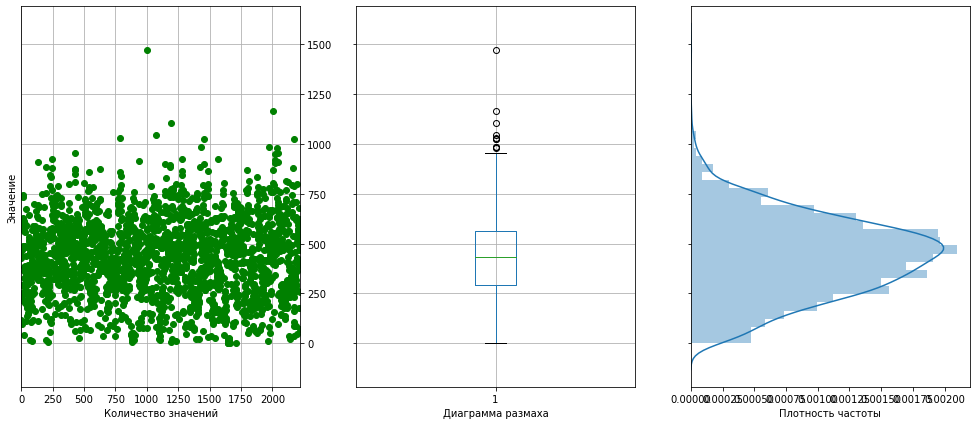

In [71]:
odindmasiv(smart_users_calls)

Среднее и медиана по звонкам у пользователей тарифа "Смарт" почти равны и расстояние от медианы до 1го квартиля и 3го квартиля также почти равны, что говорит о нормальном распределени без положительных, отрицательных сдвигов.
По диаграмме размаха можно сказать, что есть аномально высокие больше 955 минут в месяц соответственно.
95% значений находится в доверительном интервале от 42.9 до 818.3 минут в месяц

Нижний квартиль: 318.0 
Верхний квартиль: 776.5 
Нижний "ус": 1.0 
Верхний "ус": 1437.0 
Медиана: 544.0
Среднее: 560.1 
Дисперсия: 99062.6 
Стандартное отклонение: 314.7, интервал 95% [-2σ: +2σ]: -69.4 - 1189.6


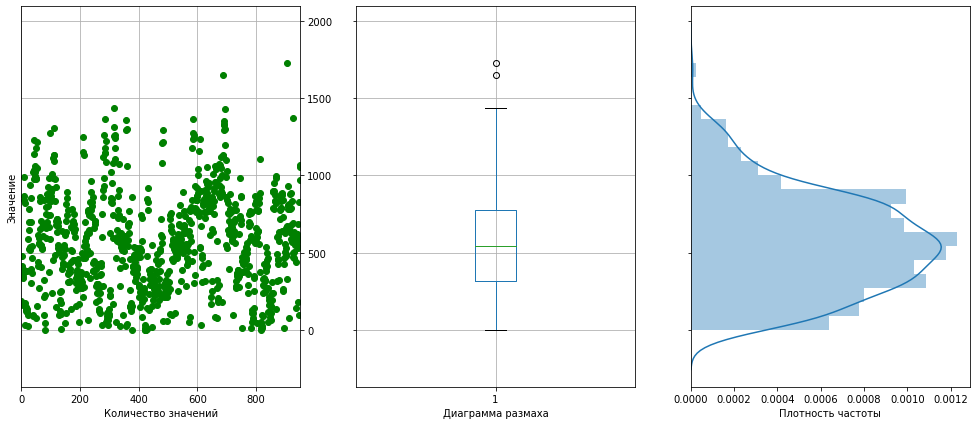

In [72]:
odindmasiv(ultra_users_calls)

Среднее и медиана по звонкам у пользователей тарифа "Ультра" почти равны и расстояние от медианы до 1го квартиля и 3го квартиля также почти равны, что говорит о нормальном распределени без положительных, отрицательных сдвигов.  
По диаграмме размаха можно сказать, что аномально низкие и аномально высокие почти отсутствуют.  
95% значений находится в доверительном интервале от 0 до 1189.6 минут в месяц

Нижний квартиль: 12659.2 
Верхний квартиль: 20044.7 
Нижний "ус": 1600.3 
Верхний "ус": 31077.5 
Медиана: 16508.6
Среднее: 16222.9 
Дисперсия: 34257208.7 
Стандартное отклонение: 5853.0, интервал 95% [-2σ: +2σ]: 4517.0 - 27928.9


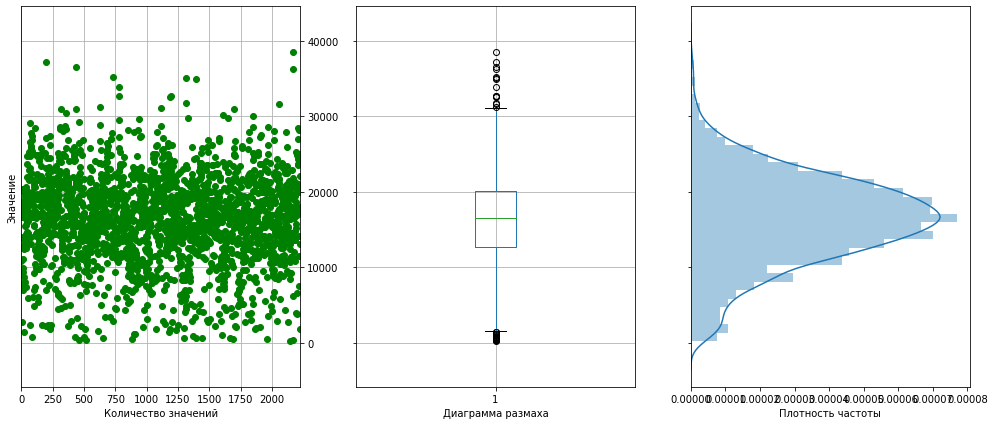

In [73]:
odindmasiv(smart_users_internet)

Среднее и медиана по интернет трафику у пользователей тарифа "Смарт" почти равны и расстояние от медианы до 1го квартиля и 3го квартиля также почти равны, что говорит о нормальном распределени без положительных, отрицательных сдвигах.  
По диаграмме размаха можно сказать, что есть аномально низкие меньше 1600 Мб и аномально высокие больше 31077 Мб в месяц соответственно.  
95% значений находится в доверительном интервале от 4517.0 до 27928.9 Мб в месяц

Нижний квартиль: 12062.4 
Верхний квартиль: 26912.2 
Нижний "ус": 365.1 
Верхний "ус": 48351.6 
Медиана: 19409.0
Среднее: 19688.7 
Дисперсия: 98567864.3 
Стандартное отклонение: 9928.1, интервал 95% [-2σ: +2σ]: -167.6 - 39544.9


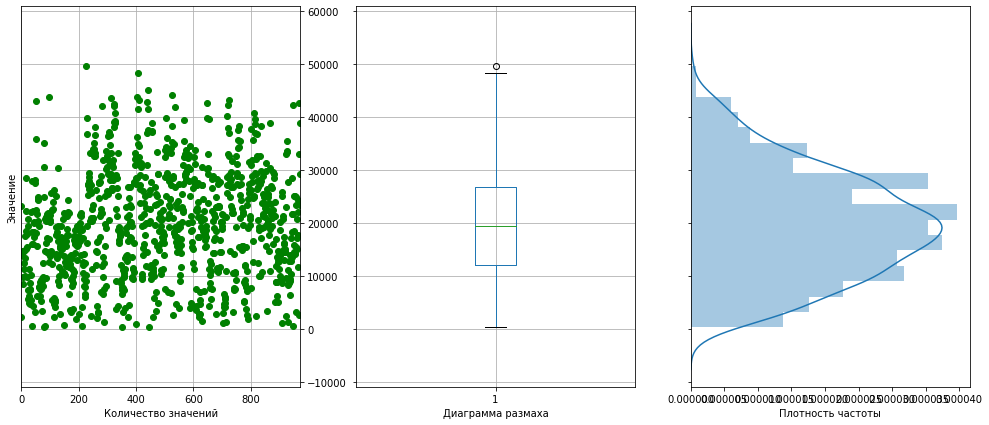

In [74]:
odindmasiv(ultra_users_internet)

Среднее и медиана по интернет трафику у пользователей тарифа "Ультра" почти равны и расстояние от медианы до 1го квартиля и 3го квартиля также почти равны(с небольшим сдвигом к 3му квартилю), что говорит в целом о нормальном распределени с небольшим положительным сдвигом.  
По диаграмме размаха можно сказать, что есть аномально низкие и аномально высокие значения почти отсутствуют.  
95% значений находится в доверительном интервале от 0 до 39544.9 Мб в месяц

Нижний квартиль: 17.0 
Верхний квартиль: 55.0 
Нижний "ус": 1.0 
Верхний "ус": 112.0 
Медиана: 34.0
Среднее: 38.7 
Дисперсия: 717.6 
Стандартное отклонение: 26.8, интервал 95% [-2σ: +2σ]: -14.9 - 92.3


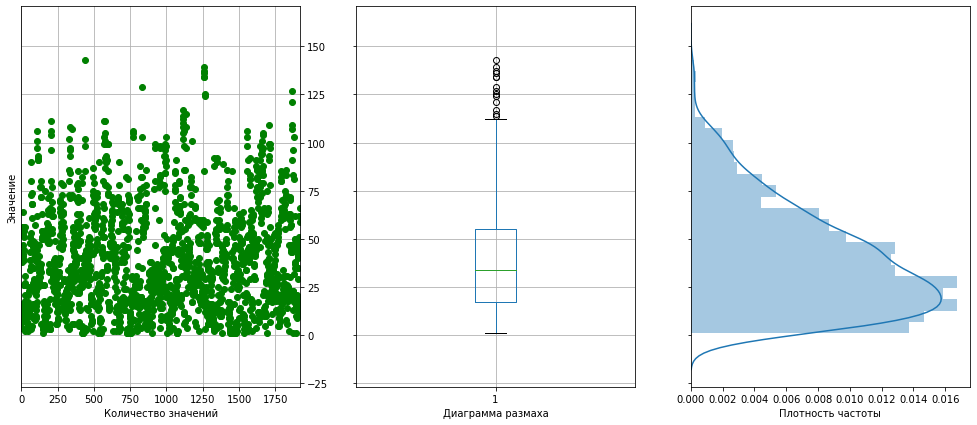

In [75]:
odindmasiv(smart_users_messages)

Среднее и медиана по сообщеним у пользователей тарифа "Смарт" почти равны и расстояние от медианы до 1го квартиля и 3го квартиля также почти равны, что говорит о нормальном распределени без положительных, отрицательных сдвигах.  
По диаграмме размаха можно сказать, что есть только аномально высокие больше 112 сообщений в месяц.  
95% значений находится в доверительном интервале от 0 до 92.3 сообщений в месяц

Нижний квартиль: 24.0 
Верхний квартиль: 87.5 
Нижний "ус": 1.0 
Верхний "ус": 182.0 
Медиана: 51.0
Среднее: 61.2 
Дисперсия: 2109.7 
Стандартное отклонение: 45.9, интервал 95% [-2σ: +2σ]: -30.7 - 153.0


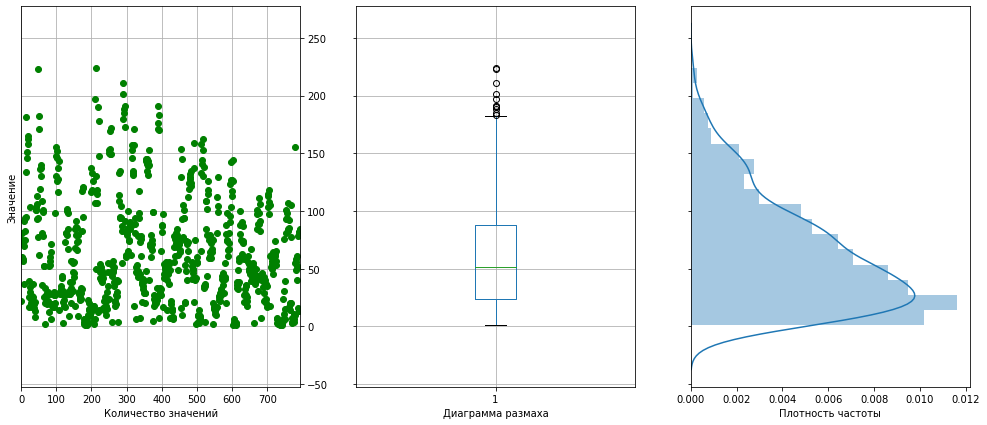

In [76]:
odindmasiv(ultra_users_messages)

Среднее и медиана по сообщеним у пользователей тарифа "Ультра" немного отличаюся, а расстояние от медианы до 1го квартиля чуть больше расстояния до 3го квартиля, что в целом говорит о нормальном распределени без сильных сдвигов.
По диаграмме размаха можно сказать, что есть только аномально высокие больше 182 сообщений в месяц.  
95% значений находится в доверительном интервале от 0 до 153 сообщений в месяц.

Вызовем функцию plots_and_values для всех исследуемых параметров:

In [46]:
plots_and_values(smart_users_calls, 'mean')

~~Среднее и медиана по звонкам у пользователей тарифа "Смарт" почти равны и расстояние от медианы до 1го квартиля и 3го квартиля также почти равны, что говорит о нормальном распределени без положительных, отрицательных сдвигов.  
По диаграмме размаха можно сказать, что есть аномально низкие меньше 12 минут и аномально высокие больше 744 минут в месяц соответственно.  
95% значений находится в доверительном интервале от 121.3 до 733.0 минут в месяц~~

In [47]:
plots_and_values(ultra_users_calls, 'mean')

~~Среднее и медиана по звонкам у пользователей тарифа "Ультра" почти равны и расстояние от медианы до 1го квартиля и 3го квартиля также почти равны, что говорит о нормальном распределени без положительных, отрицательных сдвигов.  
По диаграмме размаха можно сказать, что аномально низкие и аномально высокие отсутствуют.  
95% значений находится в доверительном интервале от 0 до 1122.9 минут в месяц~~

In [48]:
plots_and_values(smart_users_internet, 'mean')

~~Среднее и медиана по интернет трафику у пользователей тарифа "Смарт" почти равны и расстояние от медианы до 1го квартиля и 3го квартиля также почти равны, что говорит о нормальном распределени без положительных, отрицательных сдвигах.  
По диаграмме размаха можно сказать, что есть аномально низкие меньше 6794 Мб и аномально высокие больше 25653Мб в месяц соответственно.  
95% значений находится в доверительном интервале от 8445.6 до 23613.5 Мб в месяц~~

In [49]:
plots_and_values(ultra_users_internet, 'mean')

~~Среднее и медиана по интернет трафику у пользователей тарифа "Ультра" почти равны и расстояние от медианы до 1го квартиля и 3го квартиля также почти равны(с небольшим сдвигом к 3му квартилю), что говорит в целом о нормальном распределени с небольшим положительным сдвигом.  
По диаграмме размаха можно сказать, что есть аномально низкие и аномально высокие значения отсутствуют.  
95% значений находится в доверительном интервале от 2188.5 до 36117.1 Мб в месяц~~

In [50]:
plots_and_values(smart_users_messages, 'mean')

~~Среднее и медиана по сообщеним у пользователей тарифа "Смарт" почти равны и расстояние от медианы до 1го квартиля и 3го квартиля также почти равны, что говорит о нормальном распределени без положительных, отрицательных сдвигах.  
По диаграмме размаха можно сказать, что есть только аномально высокие больше 99 сообщений в месяц.  
95% значений находится в доверительном интервале от 0 до 85 сообщений в месяц~~

In [51]:
plots_and_values(ultra_users_messages, 'mean')

~~Среднее и медиана по сообщеним у пользователей тарифа "Ультра" немного отличаюся, а расстояние от медианы до 1го квартиля чуть больше расстояния до 3го квартиля, что в целом говорит о нормальном распределени без сильных сдвигах.
По диаграмме размаха можно сказать, что есть только аномально высокие больше 176 сообщений в месяц.  
95% значений находится в доверительном интервале от 0 до 146 сообщений в месяц.~~

In [52]:
def comparissonn(df):
    row =[]
    for i in range((df.shape[0])):
        cur_row =[]
        for j in range(3,15):
            cur_row.append(df.iat[i, j])
        row.append(cur_row)
    row1 = [item for elem in row for item in elem]
    row1 = [i for i in row1 if i != 0]
    #row2 = pd.Series(row1)
    row3 = pd.DataFrame(row1, columns = ['1'])
    df = row3
    return df

smart_users_calls1 = comparissonn(smart_users_calls)
ultra_users_calls1 = comparissonn(ultra_users_calls)
smart_users_messages1 = comparissonn(smart_users_messages)
ultra_users_messages1 = comparissonn(ultra_users_messages)
smart_users_internet1 = comparissonn(smart_users_internet)
ultra_users_internet1 = comparissonn(ultra_users_internet)

Напишем функцию tariff_compare, представляющая 2 тарифа на одном графике для звонков, сообщений и интернет трафика.

In [53]:
def tariff_compare(df1, df2, column):
    plt.figure(figsize=(10,5))
    sns.distplot(df1[column], color='g').set(xlabel='Значение', ylabel='Плотность частоты');
    sns.distplot(df2[column], color='b').set(xlabel='Значение', ylabel='Плотность частоты');

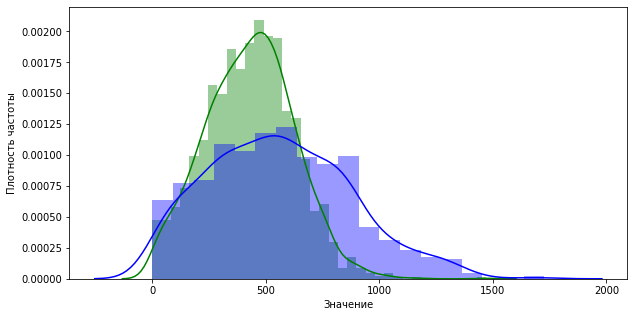

In [54]:
#tariff_compare(smart_users_calls, ultra_users_calls, 'mean')
tariff_compare(smart_users_calls1, ultra_users_calls1, '1')

~~Для тарифа "Смарт": среднее: 427.2, стандартное отклонение: 152.9, интервал 95% [-2σ: +2σ]: [121.3 : 733.0]~~

~~Для тарифа "Ультра": среднее: 531.9, стандартное отклонение: 295.5, интервал 95% [-2σ: +2σ]: [0 : 1122.9]~~

Для тарифа "Смарт": среднее: 430.0, стандартное отклонение: 193.9, интервал 95% [-2σ: +2σ]: [42.9 : 818.3]  
Для тарифа "Ультра": среднее: 560.1, стандартное отклонение: 314.7, интервал 95% [-2σ: +2σ]: [0 : 1189.6]

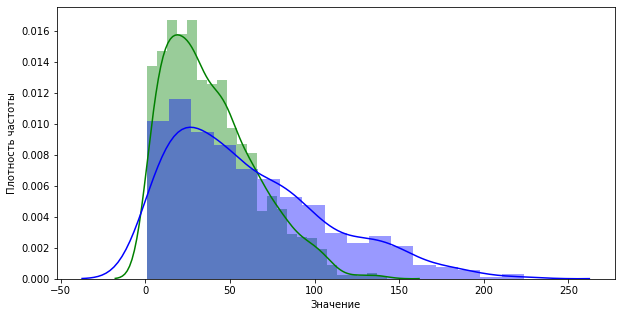

In [55]:
#tariff_compare(smart_users_messages, ultra_users_messages, 'mean')
tariff_compare(smart_users_messages1, ultra_users_messages1, '1')

~~Для тарифа "Смарт": среднее: 32.0, стандартное отклонение: 26.5, интервал 95% [-2σ: +2σ]: [0 : 85.1]~~
~~Для тарифа "Ультра": среднее: 53.1, стандартное отклонение: 46.5, интервал 95% [-2σ: +2σ]: [0 : 146.1]~~
Для тарифа "Смарт": среднее: 38.7, стандартное отклонение: 26.8, интервал 95% [-2σ: +2σ]: [0 : 92.3]  
Для тарифа "Ультра": среднее: 61.2, стандартное отклонение: 45.9, интервал 95% [-2σ: +2σ]: [0 : 153.0]

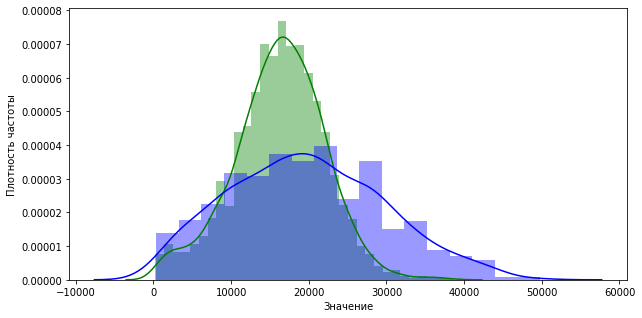

In [56]:
#tariff_compare(smart_users_internet, ultra_users_internet, 'mean')
tariff_compare(smart_users_internet1, ultra_users_internet1, '1')

~~Для тарифа "Смарт": среднее: 16029.5, стандартное отклонение: 3792.0, интервал 95% [-2σ: +2σ]: [8445.6 : 23613.5]~~
~~Для тарифа "Ультра": среднее: 19152.8, стандартное отклонение: 8482.1, интервал 95% [-2σ: +2σ]: [2188.5 : 36117.1]~~
 
Для тарифа "Смарт": среднее: 16222.9, стандартное отклонение: 5853.0, интервал 95% [-2σ: +2σ]: [4517.0 : 27928.9]  
Для тарифа "Ультра": среднее: 19688.7, стандартное отклонение: 9928.1, интервал 95% [-2σ: +2σ]: [0.0 : 39544.9]

## Выводы:
~~Для пользователей тарифа "Смарт" в среднем необходимо: 427 минут, 32 сообщения и 16029 Мб интернет трафика.~~  
~~Для пользователей тарифа "Ультра" в среднем необходимо: 532 минут, 53 сообщения и 19152 Мб интернет трафика.~~

Для пользователей тарифа "Смарт" в среднем необходимо: 430 минут, 39 сообщения и 16223 Мб интернет трафика.  
Для пользователей тарифа "Ультра" в среднем необходимо: 560 минут, 61 сообщения и 19689 Мб интернет трафика.  



По тарифнному плану "Смарт" включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика  
По тарифнному плану "Ультра" включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика  

Учитывая вышеприведенные доверительные интервалы, можно сказать для тарифа "Смарт": для половины пользователей 500 минут звонков недостаточно , 50 сообщений для большей части хватает, 15 Гб интернет-трафика хватает примерно половине пользователей.  
Учитывая вышеприведенные доверительные интервалы, можно сказать для тарифа "Ультра": 3000 минут звонков достаточно для пользователей, 1000 достаточно для пользователей, 30 Гб интернет-трафика удовлетворяет большую половину пользователей.


## Глава 4. Проверка гипотез

### Гипотеза 1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

~~Посчитаем среднюю выручку для каждого пользователя тарифа и добавим в новый столбец mean~~

In [57]:
#smart_total['mean'] = sum(smart_total[str(i) +'_total'] for i in range(1, 13)) / (13 - smart_total['month_reg'])
#ultra_total['mean'] = sum(ultra_total[str(i) +'_total'] for i in range(1, 13)) / (13 - ultra_total['month_reg'])
#smart_total

def totalizator(df):
    row =[]
    for i in range((df.shape[0])):
        cur_row =[]
        for j in range(3,15):
            cur_row.append(df.iat[i, j])
        row.append(cur_row)
    row1 = [item for elem in row for item in elem]
    row1 = [i for i in row1 if i != 0]
    #row2 = pd.Series(row1)
    row3 = pd.DataFrame(row1, columns = ['1'])
    df = row3
    return df
smart_total1 = totalizator(smart_total)
ultra_total1 = totalizator(ultra_total)

Посчитаем средную выручку для тарифа «Ультра» и «Смарт»

In [58]:
#smart_total['mean'].mean()
smart_total1['1'].mean()

1239.705725699068

In [59]:
#ultra_total['mean'].mean()
ultra_total1['1'].mean()

2057.5079522862825

Сформируем нулевую гипотезу H₀ - "Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны". Тогда альтернативная гипотеза H₁ формирует следующие утверждение: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"

In [60]:
alpha = .05 # критический уровень статистической значимости, если p-value окажется меньше него - отвергнем гипотезу

#results = st.ttest_ind(smart_total['mean'], ultra_total['mean'], equal_var = False)
results = st.ttest_ind(smart_total1['1'], ultra_total1['1'], equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 6.774630407973526e-294
Отвергаем нулевую гипотезу


Полученное p-значение позволяет отвергнуть нулевую гипотезу и говорит о том, что "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается", выручка от тарифа «Ультра» выше, чем у тарифа «Смарт»    
Получить подтверждение нулевой гипотезы ничтожно мало(гораздо меньше критического уровеня статистической значимости в 0.05)



### Гипотеза 2: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Вызовем датафрейм df_users

In [61]:
df_users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2018-12-31,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2018-12-31,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2018-12-31,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,2018-12-31,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,2018-12-31,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,2018-12-31,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Создадим срез user_age_city по id и городу пользователя

In [62]:
user_age_city = df_users.loc[:, ['user_id', 'city']]
user_age_city

,user_id,city
0,1000,Краснодар
1,1001,Москва
2,1002,Стерлитамак
3,1003,Москва
4,1004,Новокузнецк
...,...,...
495,1495,Иркутск
496,1496,Вологда
497,1497,Челябинск
498,1498,Владикавказ


Создадим срез smart_total_mean и ultra_total_mean по id и доходу от пользователя. Объеденим в общую таблицу с добавлением столбца mean

In [63]:
#smart_total_mean = smart_total.loc[:, ['user_id', 'mean']]
#ultra_total_mean = ultra_total.loc[:, ['user_id', 'mean']]
#total_mean =  (user_age_city.merge(smart_total_mean, on='user_id', how='left')
 #                           .merge(ultra_total_mean, on='user_id', how='left')
  #            ).fillna(0)
#total_mean['mean'] = total_mean['mean_x'] + total_mean['mean_y']
#total_mean

smart_totalitto = smart_total.loc[:, ['user_id', '1_total',  '2_total', '3_total', '4_total', '5_total', '6_total', '7_total', '8_total', '9_total', '10_total', '11_total', '12_total']]
ultra_totalitto = ultra_total.loc[:, ['user_id', '1_total',  '2_total', '3_total', '4_total', '5_total', '6_total', '7_total', '8_total', '9_total', '10_total', '11_total', '12_total']]
totalitto =  (user_age_city.merge(smart_totalitto, on='user_id', how='left')
                            .merge(ultra_totalitto, on='user_id', how='left')
              ).fillna(0)
totalitto

,user_id,city,1_total_x,2_total_x,3_total_x,4_total_x,5_total_x,6_total_x,7_total_x,8_total_x,9_total_x,10_total_x,11_total_x,12_total_x,1_total_y,2_total_y,3_total_y,4_total_y,5_total_y,6_total_y,7_total_y,8_total_y,9_total_y,10_total_y,11_total_y,12_total_y
0,1000,Краснодар,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1,1001,Москва,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1149.0,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1002,Стерлитамак,0.0,0.0,0.0,0.0,0.0,550.0,983.0,1518.0,809.0,550.0,1180.0,1087.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1003,Москва,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0
4,1004,Новокузнецк,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,Иркутск,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,2293.0,1950.0,3153.0,1950.0
496,1496,Вологда,550.0,3432.0,2631.0,1774.0,2180.0,1698.0,2584.0,2304.0,2810.0,3054.0,2973.0,1702.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,1497,Челябинск,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,568.0,550.0,1614.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,1498,Владикавказ,0.0,0.0,0.0,0.0,0.0,0.0,550.0,2319.0,1873.0,1569.0,550.0,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Создадим 2 среза по пользователям: Москва и остальные регионы

In [64]:
#total_mean_moscow = total_mean.query('city == "Москва"')
#total_mean_other = total_mean.query('city != "Москва"')
#total_mean_other

totalitto_mean_moscow = totalitto.query('city == "Москва"')
totalitto_mean_other = totalitto.query('city != "Москва"')
totalitto_mean_other

,user_id,city,1_total_x,2_total_x,3_total_x,4_total_x,5_total_x,6_total_x,7_total_x,8_total_x,9_total_x,10_total_x,11_total_x,12_total_x,1_total_y,2_total_y,3_total_y,4_total_y,5_total_y,6_total_y,7_total_y,8_total_y,9_total_y,10_total_y,11_total_y,12_total_y
0,1000,Краснодар,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
2,1002,Стерлитамак,0.0,0.0,0.0,0.0,0.0,550.0,983.0,1518.0,809.0,550.0,1180.0,1087.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1004,Новокузнецк,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
5,1005,Набережные Челны,550.0,550.0,928.0,1258.0,868.0,919.0,820.0,970.0,556.0,1285.0,739.0,901.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1006,Ульяновск,0.0,550.0,926.0,550.0,550.0,550.0,1451.0,1320.0,581.0,1396.0,550.0,1158.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,Иркутск,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1950.0,2293.0,1950.0,3153.0,1950.0
496,1496,Вологда,550.0,3432.0,2631.0,1774.0,2180.0,1698.0,2584.0,2304.0,2810.0,3054.0,2973.0,1702.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,1497,Челябинск,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,568.0,550.0,1614.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,1498,Владикавказ,0.0,0.0,0.0,0.0,0.0,0.0,550.0,2319.0,1873.0,1569.0,550.0,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Посчитаем средную выручку для Москвы и остальных регионов

In [65]:
#total_mean_moscow['mean'].mean()
def totalizator(df):
    row =[]
    for i in range((df.shape[0])):
        cur_row =[]
        for j in range(3,15):
            cur_row.append(df.iat[i, j])
        row.append(cur_row)
    row1 = [item for elem in row for item in elem]
    row1 = [i for i in row1 if i != 0]
    #row2 = pd.Series(row1)
    row3 = pd.DataFrame(row1, columns = ['1'])
    df = row3
    return df
totalitto_mean_moscow1 = totalizator(totalitto_mean_moscow)
totalitto_mean_moscow1.mean()

1    1202.18299
dtype: float64

In [66]:
#total_mean_other['mean'].mean()
def totalizator(df):
    row =[]
    for i in range((df.shape[0])):
        cur_row =[]
        for j in range(3,15):
            cur_row.append(df.iat[i, j])
        row.append(cur_row)
    row1 = [item for elem in row for item in elem]
    row1 = [i for i in row1 if i != 0]
    #row2 = pd.Series(row1)
    row3 = pd.DataFrame(row1, columns = ['1'])
    df = row3
    return df
totalitto_mean_other1 = totalizator(totalitto_mean_other)
totalitto_mean_other1.mean()

1    1260.998913
dtype: float64

Сформируем нулевую гипотезу H₀ - "Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов". Тогда альтернативная гипотеза H₁ формирует следующие утверждение: "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"

In [67]:
alpha = .05 # критический уровень статистической значимости, если p-value окажется меньше него - отвергнем гипотезу

#results = st.ttest_ind(total_mean_moscow['mean'], total_mean_other['mean'], equal_var = False)

results = st.ttest_ind(totalitto_mean_moscow1['1'], totalitto_mean_other1['1'], equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1557953463131759
Не получилось отвергнуть нулевую гипотезу


In [79]:
len(totalitto_mean_other1) + len(totalitto_mean_moscow1)

2228

Полученное p-значение не позволяет отвергнуть нулевую гипотезу и говорит о том, что "Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов". С вероятностью в 15% такое различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками в Москве и других регионах.

## Выводы:
Проверка 1 гипотезы показала, что средняя выручка от пользователей тарифов «Ультра» и «Смарт» различается и на тарифе «Ультра» почти в 2 раза выше, что предполагает о таком же распределение в генеральной совокупности  
Проверка 2 гипотезы показала, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов, что предполагает такое же распределение в генеральной совокупности


## Глава 5. Общий вывод

**Оптимальный тариф для пользователей**
- Учитывая приведенные выше выводы для тарифа "Смарт" - "для половины пользователей 500 минут звонков недостаточно , 50 сообщений для большей части хватает, 15 Гб интернет-трафика хватает примерно половине пользователей".  
- Учитывая приведенные выше выводы для тарифа "Ультра" - "3000 минут звонков достаточно для пользователей, 1000 достаточно для пользователей, 30 Гб интернет-трафика удовлетворяет большую часть пользователей".  
Можно сказать, что тариф "Смарт" не является оптимальным для пользователей, так как часто приводит к перерасходу минут и интернет трафика для большинства пользователей. Поэтому более оптимальным будет тариф "Ультра"  

**Прибыльный тариф для «Мегалайна»**
- В среднем выручка от пользователей тарифов «Ультра» и «Смарт» различается почти в 2 раза выше. Для телеком компании это перспективный тариф (***Ультра***) и на нем следует сфокусировать рекламный бюджет. Плюс, пользователи будут более охотно переходить на новый тариф, если по старому постоянно присутствует перерасход и сложно спрогнозировать расходы на мобильную связь в течении месяца. В то время как тариф "Ультра" почти полностью покрывает потребности 95% выборки, а значит, вероятно, и всех пользователей «Мегалайна»


In [68]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))